This one covers activations and gradients (and diagnostic stats and visualizations), batchnorm, and a 'pytorchification' of all of the previous work that wraps previous code in an API that looks like PyTorch w/ classes for layers, etc.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length, how many chars to predict next char?

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        # training row for each set of block_size chars (with '.' at end)
        for ch in w + '.':
            ix = stoi[ch] # 'next' char, after context
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # new context shifts right and adds prev 'next' char
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% for train
n2 = int(0.9*len(words)) # 10% for dev/validation and test

Xtr,  Ytr = build_dataset(words[:n1])    # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte,  Yte = build_dataset(words[n2:])    # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP (revisited, he says)
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [11]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 26.9945
  10000/ 200000: 2.4082
  20000/ 200000: 2.1997
  30000/ 200000: 2.2095
  40000/ 200000: 2.3114
  50000/ 200000: 2.0961
  60000/ 200000: 2.2502
  70000/ 200000: 2.5068
  80000/ 200000: 2.9409
  90000/ 200000: 2.5324
 100000/ 200000: 2.7696
 110000/ 200000: 2.1313
 120000/ 200000: 2.2607
 130000/ 200000: 2.3955
 140000/ 200000: 2.0824
 150000/ 200000: 2.3267
 160000/ 200000: 2.6652
 170000/ 200000: 2.1866
 180000/ 200000: 2.0533
 190000/ 200000: 1.9721


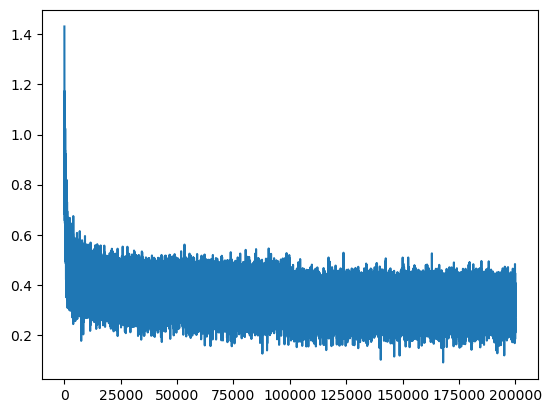

In [14]:
plt.plot(lossi)

In [10]:
@torch.no_grad() # no gradient tracking needed for inference
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat to (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


In [16]:
# sample from/inference using the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # init w/ ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the prob dist
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khi.
miliathtyn.
kansh.
esrahnel.
delynn.
jareen.
ner.
keah.
maiir.
kaleigh.
ham.
jorn.
quint.
saline.
liveni.
waxtan.
dearynix.
kael.


# Stuff we can improve - initialization

First off, he talks about how the model's not initialized well, to start with because the first loss is very high - for ex, it's ~28 above. This is high compared to what it very quickly gets to - just 10K iterations/the next time we look, it's at 2.8. 

More importantly, initially, without having seen any data, we'd expect the model to assign roughly equal probabilities to all of the 27 outcomes.

In [17]:
# approx loss if we had uniform prob 
-torch.tensor(1/27.0).log()

tensor(3.2958)

The above is an order of magnitude lower than what we actually see. This happens because the random values we assign during initialization end up producing probabilities that are very strong - high (absolute) values - when what we want is logits that are very close to zero.

We can get them close to zero by adding a '* 0' - for bias - or '* 0.1' or other small number - for weights. (Generally better to have it be a small number and not zero because there's some pathological behavior, that he named but didn't explain early on at least that zero can cause.)

In [23]:
# MLP (revisited, he says)
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [27]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 2.2264


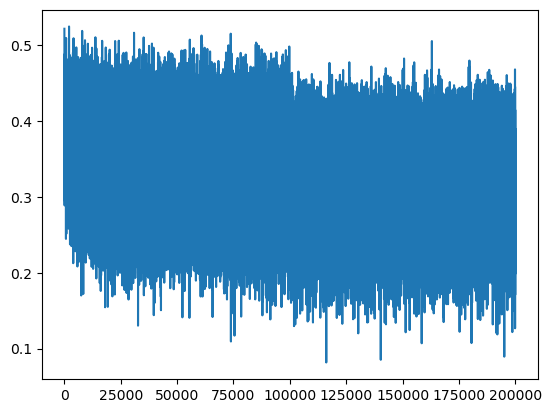

In [25]:
plt.plot(lossi)

In [26]:
split_loss('train')
split_loss('val')

train 2.0695888996124268
val 2.131074905395508


Now, we don't have the hockey stick appearance because we 'don't have to spend the first iterations squashing down the logits' and only then 'rearranging the logits'. This leads to better loss numbers because we can get immediately to optimizing and don't have to spend iterations on that 'squashing down'.

The second 'deeper' problem is still w/ the values of h - the activations of the hidden layer. If we stop after one iteration and plot a histogram with the results of the h/post tanh layer we see that the vast majority of the weights are at the extreme either end of the distribution. This happens because the tanh is a squashsing function - it returns between -1 and 1 - and the values we're feeding into the tanh are almost always less than -1 or greater than 1. 

Extreme values like this 'stop the back propagation'/'gradients will be destroyed' because the values fed in are at flat parts of the tanh curve, and the flatness means that the you can change the input and the loss won't be affected (much). 

We can see this by adding the break above so we only get one iteration, and then looking at the 'h' weights.

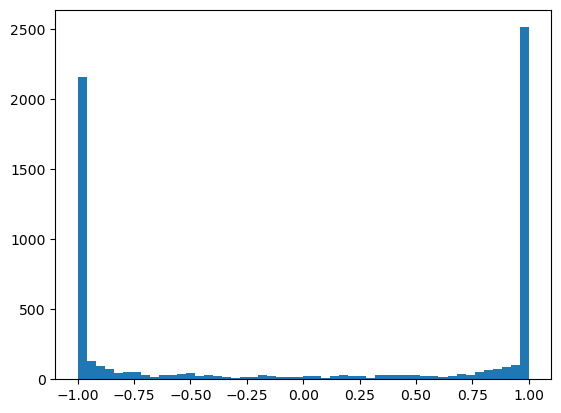

In [29]:
plt.hist(h.view(-1).tolist(), 50); # semicolon suppresses text output

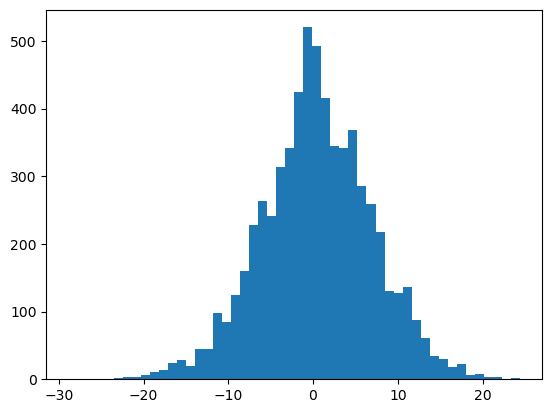

In [30]:
plt.hist(hpreact.view(-1).tolist(), 50); # semicolon suppresses text output

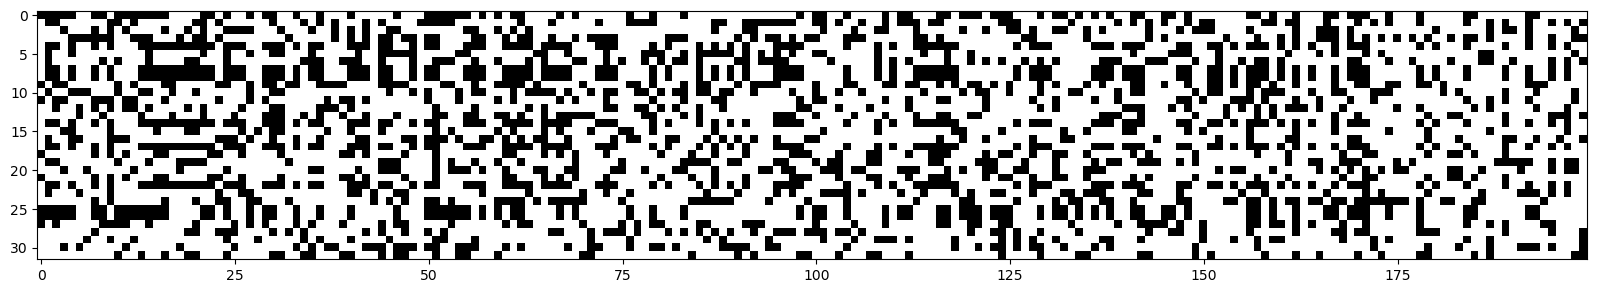

In [33]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

The above has 32 rows, one for each input in the minibatch, and 200 columns, one for each node in the hidden layer. Each place where a cell is white is one where the absolute value of the weight is > 0.99. 

First off, any column where all cells are white would indicate a 'dead neuron'. None are here. If we did see this, that'd mean that the particular neuron never learns/doesn't do anything for us - i.e., no matter what inputs the neuron gets, it always fires with a 1 or -1 and so it doesn't learn because the gradient is zeroed out. Since we don't see this, at least we can say that some of the time - with some inputs - each neuron learns. 

Then he talks about some common activation functions, many of which have flat areas and so are potentially susceptible to this kind of problem (leaky relu is one that isn't or is less susceptible because the line < 0 isn't quite flat). He also mentions how sometimes too big of a learning rate can cause neurons to zero out/be dead. 

Generally, we want values that go into the tanh - hpreact - to be a lot closer to zero. The hpreact data comes from the matmul with W1 and b1, so we'll go ahead and multiply by a 10th or 100th like we did w/ the other layer.

In [34]:
# MLP (revisited, he says)
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [39]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


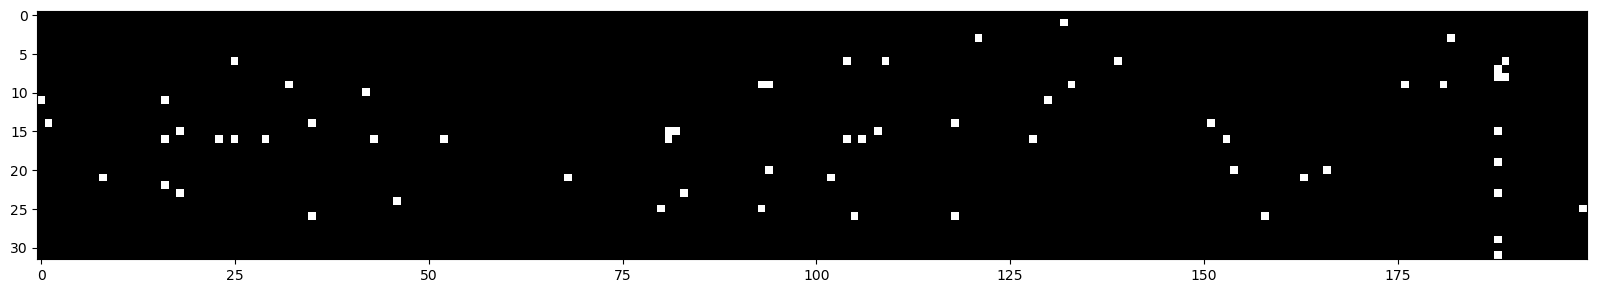

In [36]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

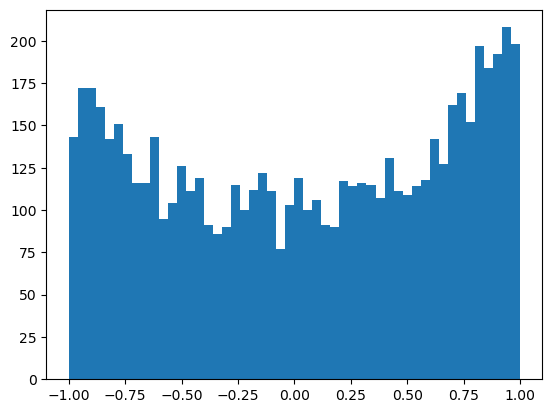

In [37]:
plt.hist(h.view(-1).tolist(), 50); # semicolon suppresses text output

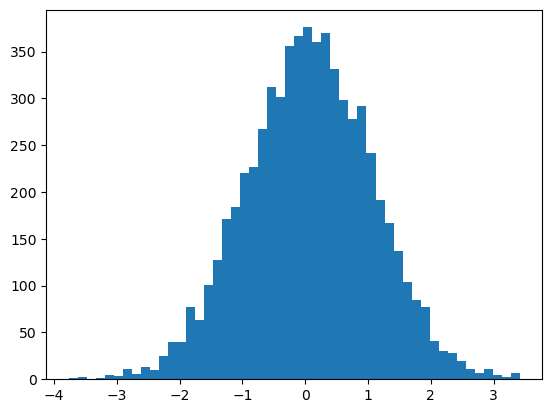

In [38]:
plt.hist(hpreact.view(-1).tolist(), 50); # semicolon suppresses text output

The above is much better - hpreact is closer to zero and only a very few neurons end up white/would zero out.

And the loss is improved. He notes that we started w/ a validation loss of 2.17, by fixing the softmax being confidently wrong we got to 2.13, and by fixing the tanh layer being too saturated at initialization we got down to 2.10.

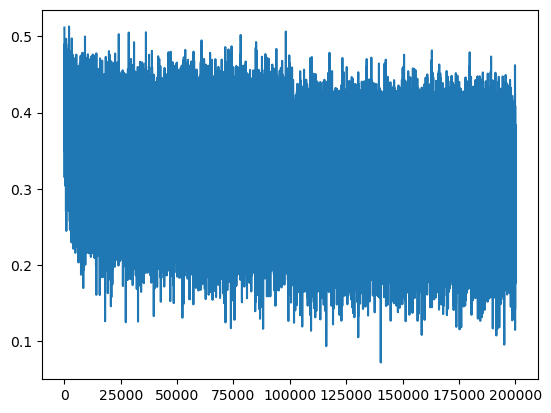

In [41]:
plt.plot(lossi)

In [40]:
split_loss('train')
split_loss('val')

train 2.0357086658477783
val 2.1029489040374756


He notes that we have a very small/shallow network, which makes things pretty resilient to bad initialization. This isn't the case when we have bigger models - like 50 layers - and in some cases things like bad initialization can keep a model from optimizing at all. The bigger the model, the more problems we may have.

# How to make numbers smaller automatically, starting with Kaiming initialization

"No one sets [the '* 0.01' (like)] numbers we set manually above manually" - instead they use techniques like the ones in this section to set them automatically.

Without any adjustment, we can see the variance of subsequent layers get larger, when we want the variance to stay roughly the same. One approach to doing this is to divide the values in the second part of the matmul by the square root of the fan in. So, if we have a second tensor that's (10, 200), we divide by the square root of 10 (same as raise 10 to the power of 0.5).

Ultimately what we want is for a network where the 'activations are well-behaved' - where they don't go to infinity or zero. He discussed this in the paper called "Delving deep into rectifiers" by Kaiming et al. This paper studies ReLU activations, which clamp all negative inputs to zero and pass through all positive inputs. To get the well-behaved network here, you need to compensate for the 'throwing away of half the distribution' with a gain - they use square root of 2 divided by the fan in (vs our prev paragraph w/ sqrt of 1/n). The paper also studies the backprop, and find that if you properly initialize the weights, you empirically don't need to do anything to make backprop work.

PyTorch has torch.nn.init_kaiming_normal_, which is "probably the most commonly used way to init neural networks now". This includes a param that adjusts the gain depending on the type of non-linearity.

Then he said he 'was going through the above pretty quickly' because a lot of it's no longer needed, due to further advances since the paper was written 7-8 years ago. Back then, you had to be super careful with init, etc. especially w/ deep networks, or they wouldn't train. Now, w/ 'advancements' it's a lot less important. 

These advancements include:

- residual connections (to come)
- using many normalization layers - batch normalization, layer normalization, etc.
- much better optimizers - no longer just SGD, but 'armas prop' (sp?) and 'adam' (also sp?).

Ultimately, what does he do in practice today? He normalizes by dividing by the square root of the fan-in, and leaves it at that, or he's a bit more complicated and uses the gain, like 5/3 for tanh. You can also use the kaiming function in pytorch, I think.

So, I'll do it here - he gets the same loss as above, but the key is that we get this w/o any magic numbers that have to be set manually - like the initial 0.2 that we got by trying different numbers and seeing what worked well. Instead, these are automatically set and give good results.

In [6]:
# MLP, now with kaiming initialization (for W1)
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [7]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [11]:
split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


# Batch normalization (one reason initialization doesn't matter as much anymore)

He talked about the Ioffe and Szegedy paper on batch normalization - a 'very impactful paper that made it possible to train deep NNs 